In [1]:
import pandas as pd
import pvlib
import matplotlib.pyplot as plt

# 1. SETUP: Restore V1 & V2 Context

# A. Define Location (Wuhan)
lat, lon = 30.59, 114.30
tz = 'Asia/Shanghai'
location = pvlib.location.Location(lat, lon, tz=tz, name='Wuhan')

# B. Load Weather Data
weather = pd.read_csv('data/raw/wuhan_tmy.csv', index_col=0, parse_dates=True)

# C. Define System Geometry (Optimal for Wuhan)
surface_tilt = 30
surface_azimuth = 180

# D. Calculate Solar Position & POA (Plane of Array)
solar_position = location.get_solarposition(weather.index)
poa_irradiance = pvlib.irradiance.get_total_irradiance(
    surface_tilt=surface_tilt,
    surface_azimuth=surface_azimuth,
    solar_zenith=solar_position['apparent_zenith'],
    solar_azimuth=solar_position['azimuth'],
    dni=weather['dni'],
    ghi=weather['ghi'],
    dhi=weather['dhi']
)

print("✅ Initialization Complete")

✅ Initialization Complete


In [2]:
# 2. PHYSICS: Calculate Cell Temperature

# Load standard parameters for an "Open Rack" mounting
params = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']
cell_temperature = pvlib.temperature.sapm_cell(
    poa_global=poa_irradiance['poa_global'],
    temp_air=weather['temp_air'],
    wind_speed=weather['wind_speed'],
    **params
)

print("✅ Cell Temperature Calculated.")

✅ Cell Temperature Calculated.


In [3]:
# Verify the model by finding the maximum temperature difference.

# Find the index (timestamp) where cell temperature is highest
hottest_time = cell_temperature.idxmax()

print(f"🔥 Hottest Moment of the Year: {hottest_time}")
print(f"Sunlight (POA): {poa_irradiance['poa_global'].loc[hottest_time]:.0f} W/m²")
print(f"Air Temp:       {weather['temp_air'].loc[hottest_time]:.1f} °C")
print(f"Panel Temp:     {cell_temperature.loc[hottest_time]:.1f} °C")

# Calculate the difference
diff = cell_temperature.loc[hottest_time] - weather['temp_air'].loc[hottest_time]
print(f"Thermal Rise: +{diff:.1f} °C")

🔥 Hottest Moment of the Year: 1990-08-05 04:00:00+00:00
Sunlight (POA): 893 W/m²
Air Temp:       37.0 °C
Panel Temp:     66.9 °C
Thermal Rise: +29.8 °C


In [4]:
# 3. POWER: Calculate DC Power Output

system_capacity_watts = 10000   # 10 kW system
temp_coeff_power = -0.004       # Loss of 0.4% per degree C (Standard for Silicon)
ref_temp = 25                   # Standard Test Conditions (STC) temperature

# The PVWatts DC Power Formula:
# Power = Rated_Size * (Sunlight / 1000) * [1 + Temp_Loss * (Actual_Temp - 25)]
dc_power = system_capacity_watts * (poa_irradiance['poa_global'] / 1000) * \
           (1 + temp_coeff_power * (cell_temperature - ref_temp))

# Solar panels don't produce negative power at night
dc_power[dc_power < 0] = 0

# Result: This Series contains the specific wattage output for every hour
print("✅ DC Power Calculated.")
print(f"Max Power Output: {dc_power.max():.0f} Watts")

✅ DC Power Calculated.
Max Power Output: 9500 Watts


FINAL RESULT: Annual Energy Yield = 15021 kWh


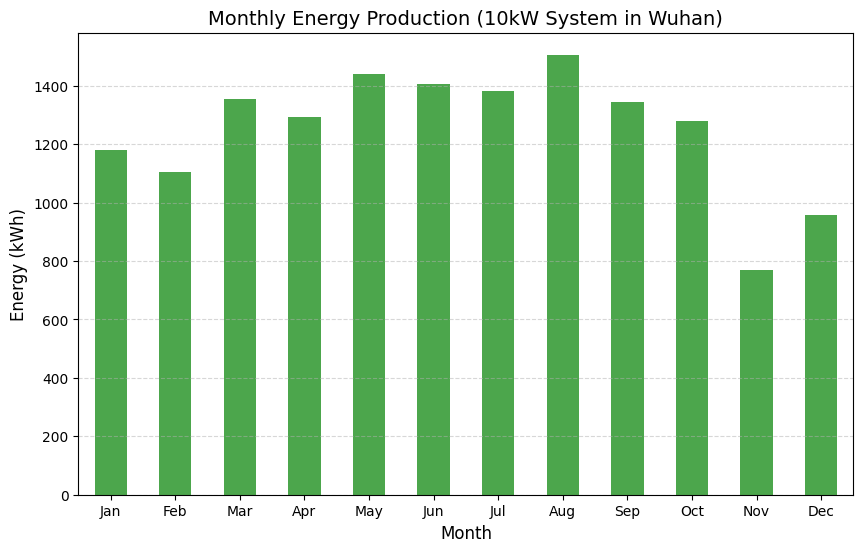

In [5]:
# 4. RESULTS: Annual Energy Yield & Monthly Chart

# Calculate Total Energy (Sum of all hours)
# Divide by 1000 to convert Watts -> kWh
annual_energy_kwh = dc_power.sum() / 1000

print(f"FINAL RESULT: Annual Energy Yield = {annual_energy_kwh:.0f} kWh")

# --- Monthly Analysis (Resampling) ---
# Sum up the energy by month ('M')
monthly_energy = dc_power.resample('ME').sum() / 1000

# Plotting the Final Report
plt.figure(figsize=(10, 6))
monthly_energy.plot(kind='bar', color='green', alpha=0.7)

# English Labels for Professionalism
plt.title('Monthly Energy Production (10kW System in Wuhan)', fontsize=14)
plt.ylabel('Energy (kWh)', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Tweak x-axis to show Month names (Jan, Feb...) instead of messy dates
tick_labels = [d.strftime('%b') for d in monthly_energy.index]
plt.xticks(range(len(monthly_energy)), tick_labels, rotation=0)

plt.show()